In [2]:
import yfinance as yf

In [3]:
df = yf.download('DIVO11.SA')
print(df.head())
print(df.describe())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker      DIVO11.SA  DIVO11.SA  DIVO11.SA  DIVO11.SA DIVO11.SA
Date                                                            
2012-01-31  30.700001  30.860001  30.700001  30.860001       310
2012-02-01  31.230000  31.230000  31.120001  31.120001      1040
2012-02-02  31.250000  31.299999  31.230000  31.299999      2610
2012-02-03  31.540001  31.600000  31.400000  31.400000        70
2012-02-06  31.350000  31.480000  31.350000  31.480000       250
Price         Close         High          Low         Open        Volume
Ticker    DIVO11.SA    DIVO11.SA    DIVO11.SA    DIVO11.SA     DIVO11.SA
count   3414.000000  3414.000000  3414.000000  3414.000000  3.414000e+03
mean      54.071239    54.548187    53.657211    54.114745  4.273478e+04
std       23.928047    24.054834    23.811799    23.927444  1.346529e+05
min       17.290001    17.309999    16.990000    17.209999  1.000000e+01
25%       33.542500    33.812501    33.279

In [4]:
df.columns = ['Close', 'Open', 'High', 'Low', 'Volume']

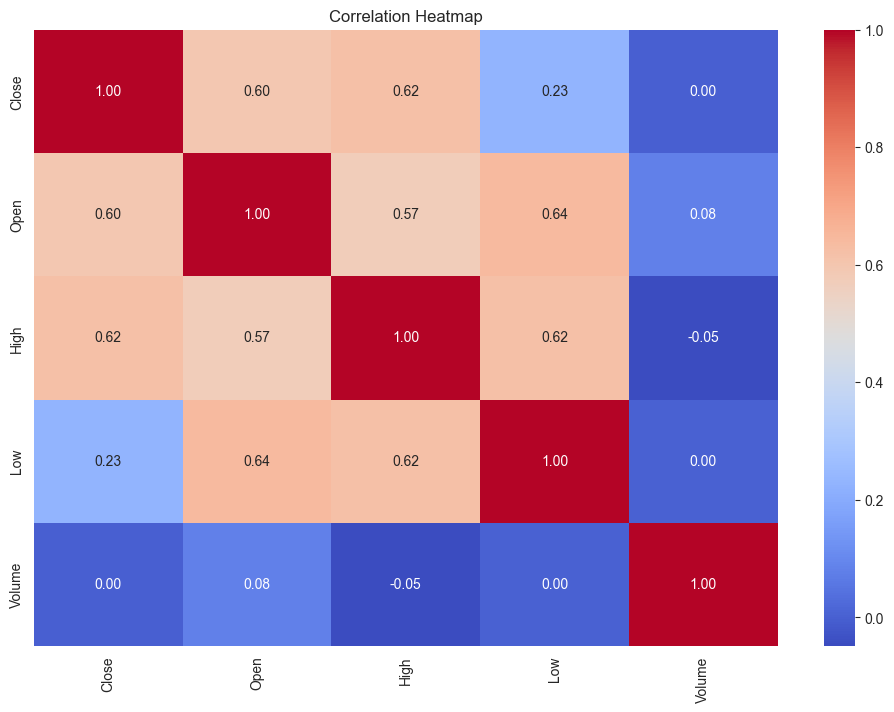

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_log = df.dropna()
df_log = np.log(df_log).diff()

plt.figure(figsize=(12, 8))
sns.heatmap(df_log.corr(), annot=True, cmap="coolwarm", fmt='.2f')
plt.xticks(rotation=90)
plt.title("Correlation Heatmap")
plt.show()

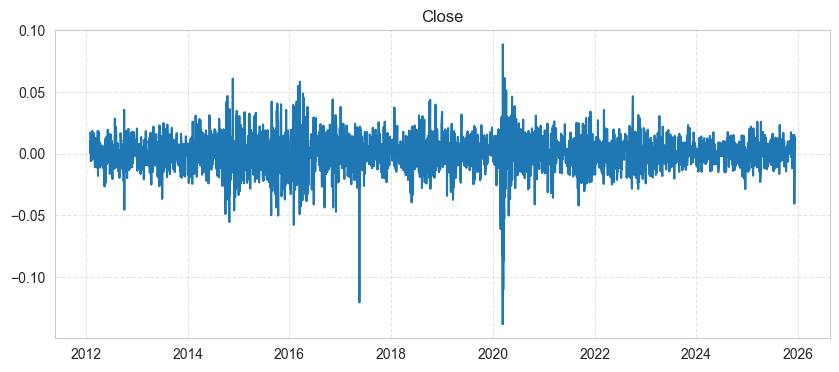

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(df_log['Close'], label='Close')
plt.grid(True, alpha=0.5, linestyle='--')
plt.title('Close')
plt.show()

#### Testing for Stationarity (ADF)

In this step, we formally test whether our three transformed series are **stationary**, a key requirement before moving on to ARMA, GARCH, or VAR modeling.

The **Augmented Dickey–Fuller (ADF) test** is used to check for the presence of a **unit root** in each time series.

* $H_0$: Series has a unit root (non-stationary)

* $H_1$: Series is stationary $I(0)$

If the **p-value < 0.05**, we reject $H_0$ and conclude that the series is **stationary**.

This step ensures that our transformed variables are suitable for modeling with ARMA, GARCH, and VAR frameworks in the subsequent stages.

In [7]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    series = series.replace([np.inf, -np.inf], np.nan).dropna()

    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]:.5f}")

for col in df_log.columns:
    print(f"--- {col} ---")
    adf_test(df_log[col])
    print()

--- Close ---
ADF Statistic: -21.67249752186214
p-value: 0.00000

--- Open ---
ADF Statistic: -9.486509389166043
p-value: 0.00000

--- High ---
ADF Statistic: -58.39474725995825
p-value: 0.00000

--- Low ---
ADF Statistic: -70.0962174703108
p-value: 0.00000

--- Volume ---
ADF Statistic: -16.386787311759086
p-value: 0.00000



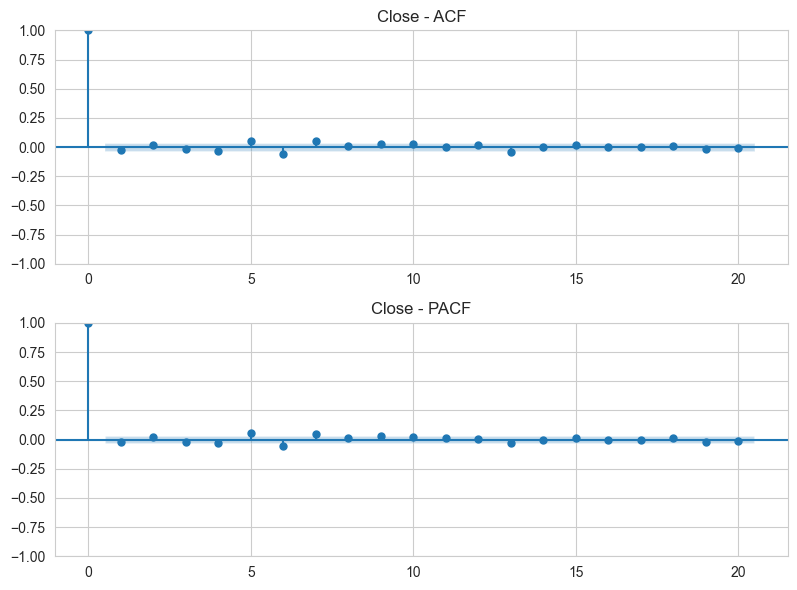

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd

col_x = pd.to_numeric(df_log['Close'], errors="coerce").dropna()
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(col_x, lags=20, ax=ax[0])
ax[0].set_title(f"Close - ACF")
plot_pacf(col_x, lags=20, method="ywm", ax=ax[1])
ax[1].set_title(f"Close - PACF")
plt.tight_layout()
plt.show()

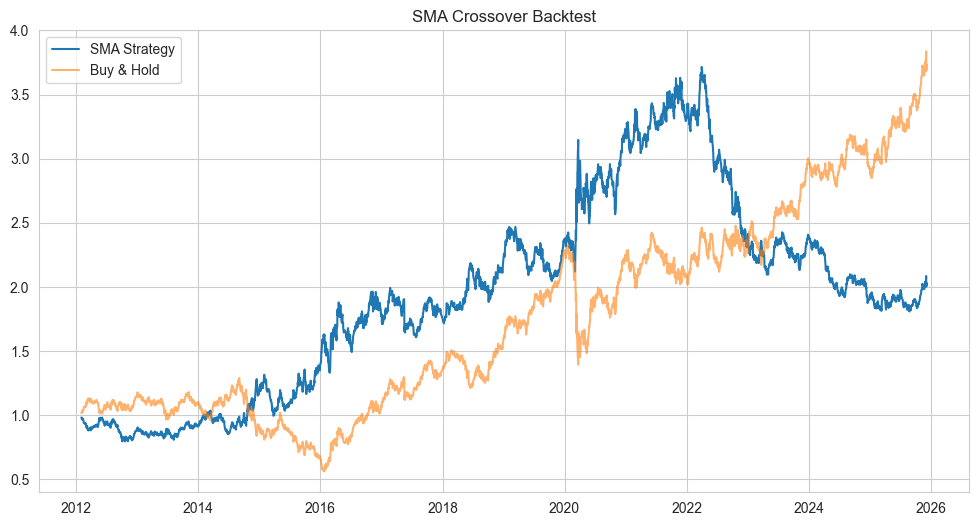

In [66]:
import talib
# Parameters
short_window = 10
long_window = 50

# Indicators

df["price"] = df["Close"]
df["sma_short"] = df["price"].rolling(short_window).mean()
df["sma_long"]  = df["price"].rolling(long_window).mean()


# Trading signal:
# +1 = long, 0 = flat
df["signal"] = np.where(df["sma_short"] > df["sma_long"], 1, -1)

# Position change (entry/exit)
df["position"] = df["signal"].shift(1).fillna(0)

# -------------------------
# Strategy returns
# -------------------------
df["returns"] = df["price"].pct_change()
df["strategy_returns"] = df["returns"] * df["position"]

# Cumulative performance
df["cumulative_strategy"] = (1 + df["strategy_returns"]).cumprod()
df["cumulative_buyhold"]  = (1 + df["returns"]).cumprod()

plt.figure(figsize=(12,6))
plt.plot(df["cumulative_strategy"], label="SMA Strategy")
plt.plot(df["cumulative_buyhold"], label="Buy & Hold", alpha=0.6)
plt.title("SMA Crossover Backtest")
plt.legend()
plt.grid(True)
plt.show()